<a href="https://colab.research.google.com/github/PaulMadhusmita/MelanomaDetection/blob/main/Madhusmita_Paul_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


Importing Necessary Libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Importing Skin Cancer Data

# Importing files from the google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!pwd

Mounted at /content/gdrive
/content


In [ ]:
!unzip  CNN_assignment.zip

Archive:  CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISIC The I

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [ ]:
# getting the count the images under train and test directories

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# Loading using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

# Create a train and validation dataset
Define some parameters for the loader and model building

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
     

Using 80% of the images for training, and 20% for validation.

In [ ]:
# Creating the Training dataset

train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
 

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Creating the Validation dataset

val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
     

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualizing the Data

Creating a code to visualize one instance of all the nine classes present in the dataset

<ipython-input-19-e7d0baf1f2f0>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i+1)


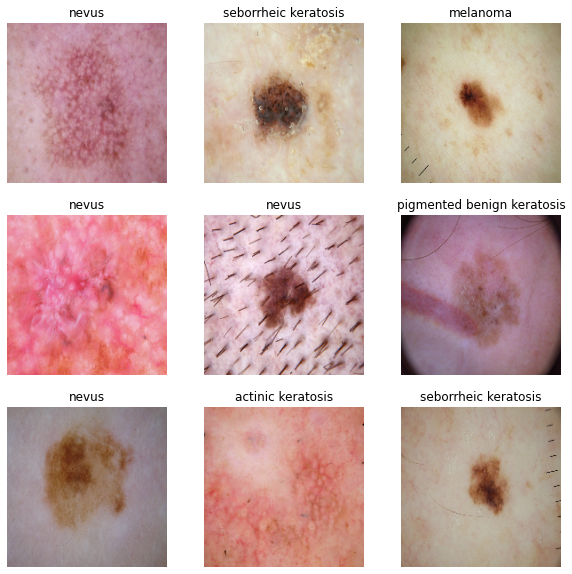

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(2):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model
Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
model = keras.Sequential()

# normalizing pixel values
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3))),
# 1st Layer
model.add(layers.Conv2D(16,3,padding='same',activation="relu")),
model.add(layers.MaxPool2D((2,2),strides=2)),
# 2nd Layer
model.add(layers.Conv2D(32,3,padding='same',activation="relu")),
model.add(layers.MaxPool2D((2,2),strides=2)),
# 3rd Layer
model.add(layers.Conv2D(64,3,padding='same',activation="relu")),
model.add(layers.MaxPool2D((2,2),strides=2)),
# Flattening into 1D array
model.add(layers.Flatten()),
# Fully Connected Dense Layer
model.add(layers.Dense(128,activation="relu")),
model.add(layers.Dense(len(class_names)))




# Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
     


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the Model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
 

Epoch 1/20
56/56 [==============================] - 83s 1s/step - loss: 1.8574 - accuracy: 0.3527 - val_loss: 1.6090 - val_accuracy: 0.4385
Epoch 2/20
56/56 [==============================] - 59s 1s/step - loss: 1.4931 - accuracy: 0.4766 - val_loss: 1.4588 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 58s 1s/step - loss: 1.3364 - accuracy: 0.5251 - val_loss: 1.4087 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 60s 1s/step - loss: 1.2909 - accuracy: 0.5407 - val_loss: 1.3511 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 58s 1s/step - loss: 1.1748 - accuracy: 0.5820 - val_loss: 1.4088 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 58s 1s/step - loss: 1.1301 - accuracy: 0.5926 - val_loss: 1.4018 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 58s 1s/step - loss: 1.0098 - accuracy: 0.6384 - val_loss: 1.3065 - val_accuracy: 0.5548
Epoch 8/20
56/56 [==

Visualizing training results

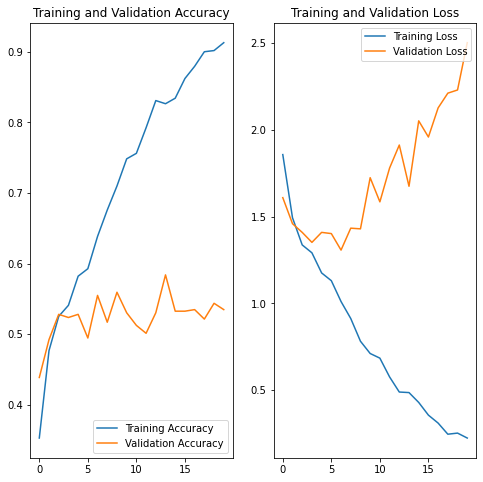

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Observation

1.   Training Accuracy : Training Accuracy is high
2.   Validation Accuracy : Validation accuracy is pretty low compared to the Training Accuracy so this model is not all a good fit. 
3.   Training Loss : Its decreasing
4.   Validation Loss : its increasing per epoch so not a good fit
5.   The model seems to have overfitten




In [ ]:
# data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)
     

Visualizing how your augmentation strategy works for one instance of training image.

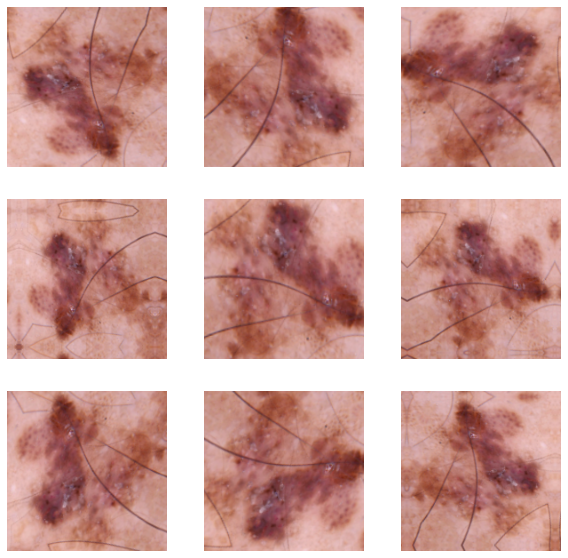

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

Creating 2nd model, compiling and training the model

As we can see there is a case of averfitting in the 1st model we created, so after augmentation we will create another model and will be using dropout layer to handle overfitting

In [ ]:
model2 = keras.Sequential()

model2.add(data_augmentation)
model2.add(layers.Rescaling(1./255))
model2.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D(2,2))
model2.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D(2,2))
model2.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D(2,2))
model2.add(layers.Dropout(0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(len(class_names)))


In [ ]:
# compiling the model

model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
#Training the model for 20 epochs

epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 71s 1s/step - loss: 1.8010 - accuracy: 0.3432 - val_loss: 1.7608 - val_accuracy: 0.3736
Epoch 2/20
56/56 [==============================] - 71s 1s/step - loss: 1.5786 - accuracy: 0.4414 - val_loss: 1.5814 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 68s 1s/step - loss: 1.4504 - accuracy: 0.4883 - val_loss: 1.5518 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 71s 1s/step - loss: 1.4562 - accuracy: 0.4872 - val_loss: 1.3439 - val_accuracy: 0.5548
Epoch 5/20
56/56 [==============================] - 68s 1s/step - loss: 1.3308 - accuracy: 0.5223 - val_loss: 1.3632 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 68s 1s/step - loss: 1.3235 - accuracy: 0.5346 - val_loss: 1.3850 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 68s 1s/step - loss: 1.2998 - accuracy: 0.5374 - val_loss: 1.2819 - val_accuracy: 0.5459
Epoch 8/20
56/56 [==

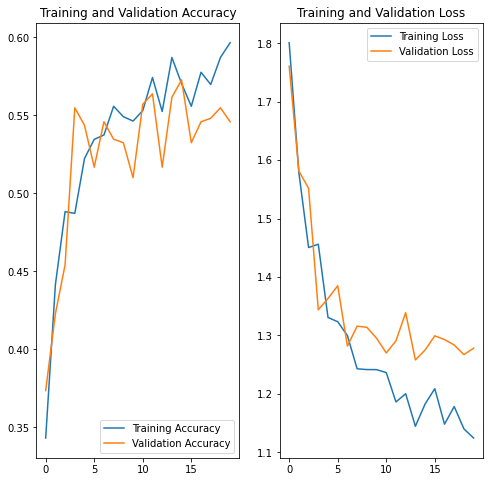

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Observation:

1. Accuracy is less than 60% for both Training & Validation sets
2. Data Augmentation & Dropout has helped deal with overfitting, and hence accuracy for both Train & Validation sets are quite closer
3. The loss for both training and validation has decreased
4. This low accuracy seems to be the case of Underfitting

### Find the distribution of classes in the training dataset.
####Context: 
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
from glob import glob
!pwd

# Creating a list of path of files in the training directory
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(path_list)
print(data_dir_train)
# list of the labels 
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(lesion_list)
# Creating a dictionary of path & labels
dataframe_dict = dict(zip(path_list, lesion_list))

# Creating dataframe for the above dictionary
df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

# Finding the count of various labels
df['Label'].value_counts()


/content/gdrive/MyDrive/ColabNotebooks
['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025953.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025992.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026040.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026149.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026171.jpg', 'Skin 

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

##### -Which class has the least number of samples?
       seborrheic keratosis

##### -Which classes dominate the data in terms proportionate number of samples?
       pigmented benign keratosis

Rectify the class imbalance:
Using a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset)+ '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD499D64490>: 100%|██████████| 500/500 [00:26<00:00, 18.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD499D895E0>: 100%|██████████| 500/500 [00:30<00:00, 16.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD499CAF280>: 100%|██████████| 500/500 [00:22<00:00, 22.12 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD499CB1580>: 100%|██████████| 500/500 [01:48<00:00,  4.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2155x1958 at 0x7FD499DDA850>: 100%|██████████| 500/500 [01:48<00:00,  4.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD49908F580>: 100%|██████████| 500/500 [00:23<00:00, 21.07 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD49288D100>: 100%|██████████| 500/500 [00:49<00:00, 10.01 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD499F6E820>: 100%|██████████| 500/500 [00:22<00:00, 22.21 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD49C5B94C0>: 100%|██████████| 500/500 [00:22<00:00, 22.47 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_a9541b42-6611-4694-967d-641e03110321.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_f6c87089-4175-46a6-9f9f-bda088dc9f6e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_599e6f1c-1961-4a81-be52-d899864af729.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_bca30668-7dc6-48d9-bd29-ea113e726d71.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_ad34b573-9046-497a-bbc5-72c2f3dea4fd.jpg']

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [ ]:
new_df['Label'].value_counts()


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Creating training dataset

data_dir_train= data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# Creating Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


###Creating model including normalization

In [ ]:
model3 = keras.Sequential()

model3.add(data_augmentation)
model3.add(layers.Rescaling(1./255))
model3.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D(2,2))
model3.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D(2,2))
model3.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D(2,2))
model3.add(layers.Dropout(0.2))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(len(class_names)))

### Compiling the model

In [ ]:
model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# Training the model

epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 237s 1s/step - loss: 1.9688 - accuracy: 0.2608 - val_loss: 1.5751 - val_accuracy: 0.4150
Epoch 2/30
169/169 [==============================] - 238s 1s/step - loss: 1.5262 - accuracy: 0.4262 - val_loss: 1.4777 - val_accuracy: 0.4558
Epoch 3/30
169/169 [==============================] - 234s 1s/step - loss: 1.4178 - accuracy: 0.4525 - val_loss: 1.3893 - val_accuracy: 0.4818
Epoch 4/30
169/169 [==============================] - 239s 1s/step - loss: 1.3583 - accuracy: 0.4751 - val_loss: 1.3642 - val_accuracy: 0.5004
Epoch 5/30
169/169 [==============================] - 235s 1s/step - loss: 1.2962 - accuracy: 0.5045 - val_loss: 1.2720 - val_accuracy: 0.5249
Epoch 6/30
169/169 [==============================] - 234s 1s/step - loss: 1.2608 - accuracy: 0.5169 - val_loss: 1.2499 - val_accuracy: 0.5308
Epoch 7/30
169/169 [==============================] - 235s 1s/step - loss: 1.2341 - accuracy: 0.5226 - val_loss: 1.1752 - val_accuracy: 0.5486

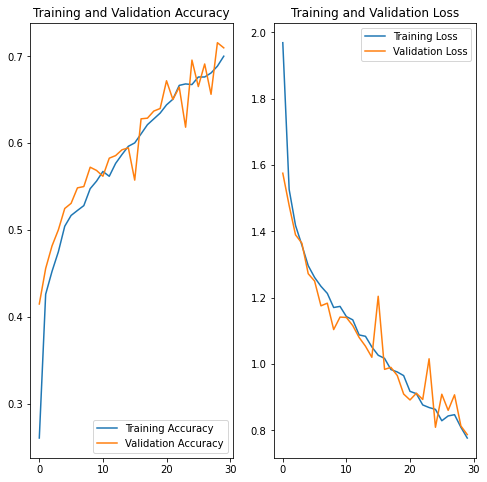

In [ ]:
# Visualizing the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


Handling class imbalance has definitely helped in improving the accuracy for both Train & Test set.
Including Normalization, Augmentation , dropouts and class rebalance has helped overcoming overfitting & underfitting
Yet the model has accuracy ~ 70%, and there scope of further improvement which cant be achieved by adding more covulation layers and dropout layers  